In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
data = pd.read_csv("../data/preprocess/airbnb_nyc_cleaned.csv")

In [25]:
data.head()

,host_identity_verified,neighbourhood_group,instant_bookable,cancellation_policy,room_type,construction_year,price,minimum_nights,number_of_reviews,last_review,...,calculated_host_listings_count,availability_365,has_house_rules,occupancy_rate,fully_unavailable,host_type,construction_category,price_category,minimum_nights_category,host_category
0,unconfirmed,Brooklyn,False,strict,Private room,2020.0,966.0,10.0,9.0,2021-10-19,...,6.0,286.0,True,0.216438,False,Multi-listing Host,new,high,Monthly,Medium Multi-Listing Host
1,verified,Manhattan,False,moderate,Entire home/apt,2007.0,142.0,30.0,45.0,2022-05-21,...,2.0,228.0,True,0.375342,False,Multi-listing Host,medium,low,Monthly,Small Multi-Listing Host
2,unconfirmed,Manhattan,True,flexible,Private room,2005.0,620.0,3.0,0.0,NaN,...,1.0,352.0,True,0.035616,False,Single-listing Host,old,medium,Weekly,Single Listing Host
3,unconfirmed,Brooklyn,True,moderate,Entire home/apt,2005.0,368.0,30.0,270.0,2019-07-05,...,1.0,322.0,False,0.117808,False,Single-listing Host,old,medium,Monthly,Single Listing Host
4,verified,Manhattan,False,moderate,Entire home/apt,2009.0,204.0,10.0,9.0,2018-11-19,...,1.0,289.0,True,0.208219,False,Single-listing Host,medium,low,Monthly,Single Listing Host


In [26]:
data.columns

Index(['host_identity_verified', 'neighbourhood_group', 'instant_bookable',
       'cancellation_policy', 'room_type', 'construction_year', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'review_rate_number', 'calculated_host_listings_count',
       'availability_365', 'has_house_rules', 'occupancy_rate',
       'fully_unavailable', 'host_type', 'construction_category',
       'price_category', 'minimum_nights_category', 'host_category'],
      dtype='object')

In [4]:
cluster_features = data[
    [
        'price',
        'number_of_reviews',
        'minimum_nights',
        'occupancy_rate'
    ]
].copy()


In [28]:
cluster_features.describe()

,price,number_of_reviews,minimum_nights,occupancy_rate
count,101908.000000,101908.000000,101908.000000,101908.000000
mean,625.301654,27.475527,7.701800,0.616632
std,331.242300,49.538684,16.656217,0.364924
min,50.000000,0.000000,1.000000,0.000000
25%,341.000000,1.000000,2.000000,0.265753
50%,625.000000,7.000000,3.000000,0.736986
75%,912.000000,30.000000,5.000000,0.991781
max,1200.000000,1024.000000,500.000000,1.027397


In [5]:
cluster_features['number_of_reviews'] = np.log1p(cluster_features['number_of_reviews'])

In [6]:
cluster_features['price'] = np.log1p(cluster_features['price'])

In [7]:
cluster_features['occupancy_rate'] = cluster_features['occupancy_rate'].clip(upper=1)

In [8]:
cluster_features['minimum_nights'] = np.log1p(cluster_features['minimum_nights'])

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_features)


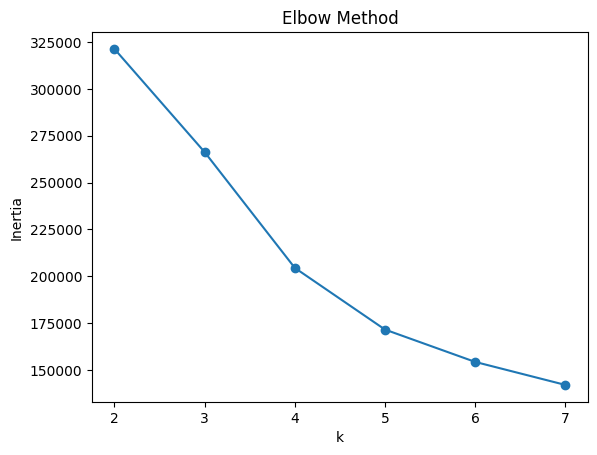

In [34]:
from sklearn.cluster import KMeans

inertia = []
K = range(2, 8)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


- 5 is optimal 

In [35]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_features['cluster'] = kmeans.fit_predict(X_scaled)


In [36]:
cluster_features['cluster'].value_counts()

cluster
0    28001
4    22563
1    20473
3    15820
2    15051
Name: count, dtype: int64

In [37]:
cluster_summary = (
    cluster_features.groupby('cluster')[cluster_features.columns]
    .mean()
    .round(2)
)

cluster_summary

,price,number_of_reviews,minimum_nights,occupancy_rate,cluster
cluster,,,,,
0,6.53,1.05,1.30,0.90,0.0
1,6.45,2.39,1.15,0.14,1.0
2,4.92,2.23,1.33,0.69,2.0
3,6.30,1.60,3.41,0.46,3.0
4,6.50,3.89,1.16,0.76,4.0


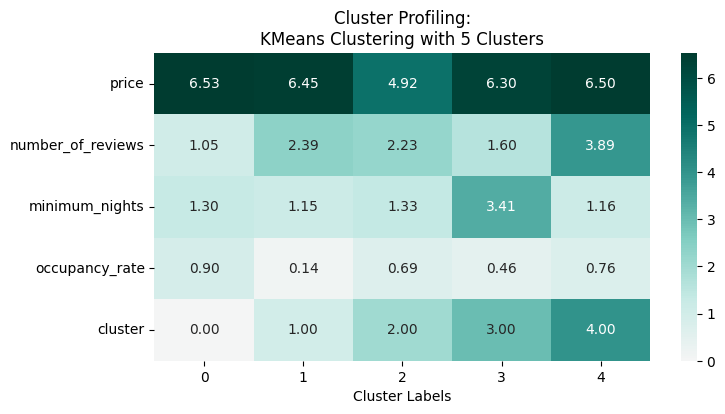

In [38]:
fig, ax = plt.subplots(figsize=(8,4))

km_profile = cluster_summary.T

sns.heatmap(km_profile,
            center=0, annot=True, cmap="BrBG", fmt=".2f",
            ax=ax 
            )

ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nKMeans Clustering with 5 Clusters")
plt.show()

- Cluster 0 — High Occupancy, Low Engagement
- Cluster 1 — Low Occupancy, Moderate Reviews
- Cluster 2 — Balanced Listings
- Cluster 3 — Long-Term Rentals
- Cluster 4 — High Engagement Listings

----